<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [124]:
import os
import numpy as np
import pandas as pd
import torch
from torchvision import datasets
from tqdm import tqdm_notebook as tqdm
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

transform = transforms.Compose([transforms.RandomRotation(10),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(
                                    brightness=0.4,
                                    contrast=0.4,
                                    saturation=0.4,
                                    hue=0.1
                                ),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

#specify a simpler transform for validation and test
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
data_dir = os.getcwd() + '\\data\\'
train_dir = os.path.join(data_dir, 'train\\')
valid_dir = os.path.join(data_dir, 'valid\\')
test_dir = os.path.join(data_dir, 'test\\')
train_data = datasets.ImageFolder(train_dir, transform=transform)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = ImageFolderWithPaths(test_dir, transform=test_transforms)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=False)

loaders = {'train' : train_loader, 'valid': valid_loader, 'test': test_loader}

In [109]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, valid_loss_min = np.Inf):
    """returns trained model"""    
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(tqdm(loaders['train'])):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)            
            loss.backward()
            optimizer.step()
            
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(tqdm(loaders['valid'])):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    columns=['Id', 'task_1', 'task_2']
    probabilities = pd.DataFrame(columns=columns)

    model.eval()
    for batch_idx, (data, target, file_path) in enumerate(tqdm(loaders['test'])):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        prob = torch.nn.Softmax(dim=1)(output.data)
        prob = prob[:, [0,2]].cpu().numpy()
        probabilities = probabilities.append(
            pd.DataFrame({'Id': np.array([f[f.find('data')].replace('\\','/') for f in file_path]), 
                          'task_1': prob[:,0], 
                          'task_2': prob[:,1]}, columns=columns), ignore_index=True)
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

    return probabilities.sort_values('Id')

In [111]:
import torchvision.models as models
import torch.nn as nn


## TODO: Specify model architecture 
#model_transfer = models.vgg16(pretrained=True)
model_transfer = models.densenet161(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier.in_features

last_layer = nn.Sequential(nn.Dropout(0.25),
                          nn.Linear(n_inputs, 256),
                          nn.ReLU(),
                          nn.Dropout(0.25),
                          nn.BatchNorm1d(256),
                          nn.Linear(256, 3),
                          )

# new layers automatically have requires_grad = True
#last_layer = nn.Linear(n_inputs, 3)

model_transfer.classifier = last_layer

use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()
        

C:\Users\lange\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [112]:
n_inputs

2208

In [113]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
#optimizer_transfer = optim.Adagrad(model_transfer.classifier[6].parameters(), lr=0.01)
optimizer_transfer = optim.RMSprop(model_transfer.classifier.parameters(), lr=0.01)

In [115]:
# load the model that got the best validation accuracy from previous training sessions
if os.path.exists('model_transfer2.pt'):
    model_transfer.load_state_dict(torch.load('model_transfer2.pt'))

# train the model
n_epochs=15
model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer2.pt')























  0%|                                                                                          | 0/100 [00:00<?, ?it/s]





















  1%|▊                                                                                 | 1/100 [00:29<49:20, 29.90s/it]





















  2%|█▋                                                                                | 2/100 [00:52<45:23, 27.79s/it]





















  3%|██▍                                                                               | 3/100 [01:17<43:18, 26.79s/it]





















  4%|███▎                                                                              | 4/100 [01:43<42:24, 26.51s/it]





















  5%|████                                                                              | 5/100 [02:06<40:35, 25.64s/it]





















  6%|████▉                                                                             | 6/100 [02:30<39:22, 25.13s/it]














 58%|██████████████████████████████████████████████▉                                  | 58/100 [24:20<18:47, 26.85s/it]





















 59%|███████████████████████████████████████████████▊                                 | 59/100 [24:46<18:09, 26.58s/it]





















 60%|████████████████████████████████████████████████▌                                | 60/100 [25:11<17:17, 25.94s/it]





















 61%|█████████████████████████████████████████████████▍                               | 61/100 [25:35<16:29, 25.38s/it]





















 62%|██████████████████████████████████████████████████▏                              | 62/100 [25:59<15:53, 25.10s/it]





















 63%|███████████████████████████████████████████████████                              | 63/100 [26:24<15:28, 25.10s/it]





















 64%|███████████████████████████████████████████████████▊                             | 64/100 [26:50<15:05, 25.14s/it]





















 65%|████████

Epoch: 1 	Training Loss: 0.786816 	Validation Loss: 0.933181
Validation loss decreased (inf --> 0.933181).  Saving model ...
























  0%|                                                                                          | 0/100 [00:00<?, ?it/s]





















  1%|▊                                                                                 | 1/100 [00:24<39:52, 24.17s/it]





















  2%|█▋                                                                                | 2/100 [00:48<39:30, 24.18s/it]





















  3%|██▍                                                                               | 3/100 [01:13<39:26, 24.39s/it]





















  4%|███▎                                                                              | 4/100 [01:38<39:28, 24.67s/it]





















  5%|████                                                                              | 5/100 [02:03<39:19, 24.83s/it]





















  6%|████▉                                                                             | 6/100 [02:29<39:10, 25.01s/it]














 58%|██████████████████████████████████████████████▉                                  | 58/100 [24:47<16:52, 24.10s/it]





















 59%|███████████████████████████████████████████████▊                                 | 59/100 [25:11<16:32, 24.21s/it]





















 60%|████████████████████████████████████████████████▌                                | 60/100 [25:36<16:11, 24.30s/it]





















 61%|█████████████████████████████████████████████████▍                               | 61/100 [25:59<15:33, 23.93s/it]





















 62%|██████████████████████████████████████████████████▏                              | 62/100 [26:24<15:20, 24.22s/it]





















 63%|███████████████████████████████████████████████████                              | 63/100 [26:49<15:13, 24.69s/it]





















 64%|███████████████████████████████████████████████████▊                             | 64/100 [27:14<14:49, 24.72s/it]





















 65%|████████

Epoch: 2 	Training Loss: 0.702321 	Validation Loss: 0.850104
Validation loss decreased (0.933181 --> 0.850104).  Saving model ...
























  0%|                                                                                          | 0/100 [00:00<?, ?it/s]





















  1%|▊                                                                                 | 1/100 [00:26<44:29, 26.97s/it]





















  2%|█▋                                                                                | 2/100 [00:52<43:24, 26.57s/it]





















  3%|██▍                                                                               | 3/100 [01:17<42:08, 26.07s/it]





















  4%|███▎                                                                              | 4/100 [01:44<42:11, 26.37s/it]





















  5%|████                                                                              | 5/100 [02:09<41:05, 25.96s/it]





















  6%|████▉                                                                             | 6/100 [02:33<39:31, 25.23s/it]














 58%|██████████████████████████████████████████████▉                                  | 58/100 [24:23<17:52, 25.54s/it]





















 59%|███████████████████████████████████████████████▊                                 | 59/100 [24:47<17:08, 25.08s/it]





















 60%|████████████████████████████████████████████████▌                                | 60/100 [25:13<16:47, 25.19s/it]





















 61%|█████████████████████████████████████████████████▍                               | 61/100 [25:39<16:29, 25.38s/it]





















 62%|██████████████████████████████████████████████████▏                              | 62/100 [26:04<16:09, 25.51s/it]





















 63%|███████████████████████████████████████████████████                              | 63/100 [26:30<15:42, 25.48s/it]





















 64%|███████████████████████████████████████████████████▊                             | 64/100 [26:54<15:07, 25.20s/it]





















 65%|████████

Epoch: 3 	Training Loss: 0.666115 	Validation Loss: 0.829862
Validation loss decreased (0.850104 --> 0.829862).  Saving model ...
























  0%|                                                                                          | 0/100 [00:00<?, ?it/s]





















  1%|▊                                                                                 | 1/100 [00:27<44:54, 27.22s/it]





















  2%|█▋                                                                                | 2/100 [00:54<44:17, 27.12s/it]





















  3%|██▍                                                                               | 3/100 [01:23<45:09, 27.94s/it]





















  4%|███▎                                                                              | 4/100 [01:49<43:46, 27.36s/it]





















  5%|████                                                                              | 5/100 [02:12<41:09, 25.99s/it]





















  6%|████▉                                                                             | 6/100 [02:37<40:20, 25.75s/it]














 58%|██████████████████████████████████████████████▉                                  | 58/100 [24:08<17:23, 24.85s/it]





















 59%|███████████████████████████████████████████████▊                                 | 59/100 [24:32<16:56, 24.79s/it]





















 60%|████████████████████████████████████████████████▌                                | 60/100 [25:01<17:16, 25.90s/it]





















 61%|█████████████████████████████████████████████████▍                               | 61/100 [25:26<16:41, 25.69s/it]





















 62%|██████████████████████████████████████████████████▏                              | 62/100 [25:51<16:11, 25.55s/it]





















 63%|███████████████████████████████████████████████████                              | 63/100 [26:16<15:38, 25.36s/it]





















 64%|███████████████████████████████████████████████████▊                             | 64/100 [26:44<15:39, 26.11s/it]





















 65%|████████

Epoch: 4 	Training Loss: 0.674899 	Validation Loss: 0.843524
























  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [125]:
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.0001)

n_epochs=15
model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer2.pt', 0.829862)















































































































































Exception ignored in: <bound method tqdm.__del__ of   0%|                                                                                          | 0/100 [42:27<?, ?it/s]>
Traceback (most recent call last):
  File "C:\Users\lange\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 931, in __del__
    self.close()
  File "C:\Users\lange\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "C:\Users\lange\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "C:\Users\lange\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 52, in exit
    self.join()
  File "C:\Users\lange\Anaconda3\lib\threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread



Epoch: 1 	Training Loss: 0.692494 	Validation Loss: 1.033045



Epoch: 2 	Training Loss: 0.686690 	Validation Loss: 1.013058


KeyboardInterrupt: 

In [69]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer2.pt'))

In [116]:
predictions = test(loaders, model_transfer, criterion_transfer, use_cuda)
predictions.to_csv('predictions2.csv')
























  0%|                                                                                           | 0/30 [00:00<?, ?it/s]






















  3%|██▊                                                                                | 1/30 [00:22<10:55, 22.59s/it]






















  7%|█████▌                                                                             | 2/30 [00:44<10:29, 22.48s/it]






















 10%|████████▎                                                                          | 3/30 [01:07<10:06, 22.48s/it]






















 13%|███████████                                                                        | 4/30 [01:34<10:21, 23.91s/it]






















 17%|█████████████▊                                                                     | 5/30 [02:08<11:13, 26.93s/it]






















 20%|████████████████▌                                                                  | 6/30 [02:38<11:10, 27.95s/it]







Test Loss: 0.690525


Test Accuracy: 71% (430/600)


In [90]:
predictions = test(loaders, model_transfer, criterion_transfer, use_cuda)
predictions.to_csv('predictions.csv')























  0%|                                                                                           | 0/30 [00:00<?, ?it/s]





















  3%|██▊                                                                                | 1/30 [00:28<13:47, 28.52s/it]





















  7%|█████▌                                                                             | 2/30 [01:00<13:50, 29.67s/it]





















 10%|████████▎                                                                          | 3/30 [01:29<13:13, 29.39s/it]





















 13%|███████████                                                                        | 4/30 [02:00<12:59, 29.99s/it]





















 17%|█████████████▊                                                                     | 5/30 [02:43<14:06, 33.87s/it]





















 20%|████████████████▌                                                                  | 6/30 [03:22<14:07, 35.33s/it]














Test Loss: 0.672915


Test Accuracy: 72% (433/600)


In [117]:
predictions = predictions.as_matrix(columns=['task_1', 'task_2'])

C:\Users\lange\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [118]:
def get_ground_truth():
    # get ground truth labels for test dataset
    truth = pd.read_csv('ground_truth.csv')
    y_true = truth.as_matrix(columns=["task_1", "task_2"])
    return y_true

In [119]:
def get_predictions():
    # get ground truth labels for test dataset
    truth = pd.read_csv('predictions.csv')
    y_true = truth.as_matrix(columns=["task_1", "task_2"])
    return y_true

In [120]:
def get_sample_predictions():
    truth = pd.read_csv('sample_predictions.csv')
    y_true = truth.as_matrix(columns=["task_1", "task_2"])
    return y_true

C:\Users\lange\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


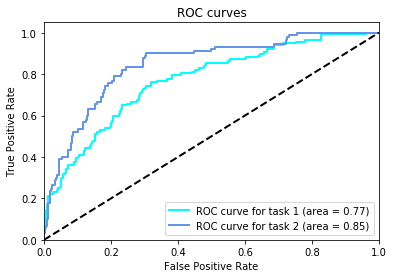

Category 1 Score: 0.769
Category 2 Score: 0.845
Category 3 Score: 0.807


In [121]:
from get_results import plot_roc_auc, plot_confusion_matrix

y_true = get_ground_truth()

plot_roc_auc(y_true, predictions)

In [104]:
def step(x, threshold=0):
    return np.sign(np.sign(x-threshold)+1)

def minimum_cost_threshold(y_true, y_pred, costs=(1, 1)):
    '''
    Find the decision threshold that minimizes the cost of errors.
    
    costs=(false_positive_cost, false_negative_cost)
    '''
    def error(x, costs):
        return costs[0]*step(-x, 0.99) + costs[1]*step(x,0.99)
    costs = np.array(costs)
    costs = costs/np.sum(costs)
    min_cost = np.inf
    min_threshold = 0
    for threshold in np.arange(0, 1, 0.001):
        y_pred_bin = np.ceil(y_pred - threshold)
#         cost = np.abs(y_true - y_pred_bin)*np.apply_along_axis(lambda i: costs[i[0]], 0, y_true)
        cost = error(y_true-y_pred_bin, costs)
        if np.mean(cost) < min_cost:
#             print(cost[:10])
            min_cost = np.mean(cost)
            min_threshold = threshold
    return min_threshold

def plot_best_confusion_matrix(y_true, y_pred, costs=(1,1)):
    threshold = minimum_cost_threshold(y_true, y_pred, costs=costs)
    print('Best threshold: %0.2f' % threshold)
    plot_confusion_matrix(y_true, y_pred, threshold, ['benign', 'malignant'])

Best threshold: 0.12


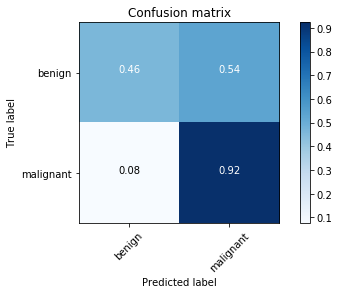

In [105]:
plot_best_confusion_matrix(y_true[:, 0], predictions[:, 0], costs=(1,10))

Best threshold: 0.14


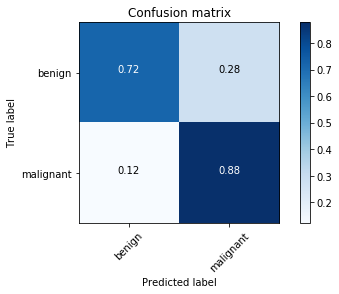

In [106]:
plot_best_confusion_matrix(y_true[:, 1], predictions[:, 1], costs=(1,10))

In [45]:
# load the model that got the best validation accuracy from previous training sessions
model_transfer.load_state_dict(torch.load('model_transfer2.pt'))

# train the model
n_epochs=15
model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer2.pt')



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

  1%|▊                                                                                 | 1/100 [00:24<40:04, 24.29s/it]

  2%|█▋                                                                                | 2/100 [00:51<41:09, 25.20s/it]

  3%|██▍                                                                               | 3/100 [01:18<41:47, 25.85s/it]

  4%|███▎                                                                              | 4/100 [01:45<41:37, 26.02s/it]

  5%|████                                                                              | 5/100 [02:11<41:08, 25.99s/it]

  6%|████▉                                                                             | 6/100 [02:40<42:02, 26.83s/it]

  7%|█████▋                                                                            | 7/100 [03:07<41:53, 27.03s/it]

  8%|██████▌                  

Epoch: 1 	Training Loss: 0.654738 	Validation Loss: 0.750791
Validation loss decreased (inf --> 0.750791).  Saving model ...




  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

  1%|▊                                                                                 | 1/100 [00:24<40:16, 24.40s/it]

  2%|█▋                                                                                | 2/100 [00:49<40:22, 24.72s/it]

KeyboardInterrupt: 

In [48]:
model_transfer.load_state_dict(torch.load('model_transfer2.pt'))

In [49]:
test(loaders, model_transfer, criterion_transfer, use_cuda)





  0%|                                                                                           | 0/30 [00:00<?, ?it/s]



  3%|██▊                                                                                | 1/30 [00:25<12:26, 25.75s/it]



  7%|█████▌                                                                             | 2/30 [00:52<12:10, 26.09s/it]



 10%|████████▎                                                                          | 3/30 [01:16<11:26, 25.43s/it]



 13%|███████████                                                                        | 4/30 [01:42<11:03, 25.50s/it]



 17%|█████████████▊                                                                     | 5/30 [02:09<10:48, 25.94s/it]



 20%|████████████████▌                                                                  | 6/30 [02:35<10:25, 26.08s/it]



 23%|███████████████████▎                                                               | 7/30 [03:01<09:57, 25.96s/it]



 27%|███████

Test Loss: 0.672915


Test Accuracy: 72% (433/600)
